# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [1]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

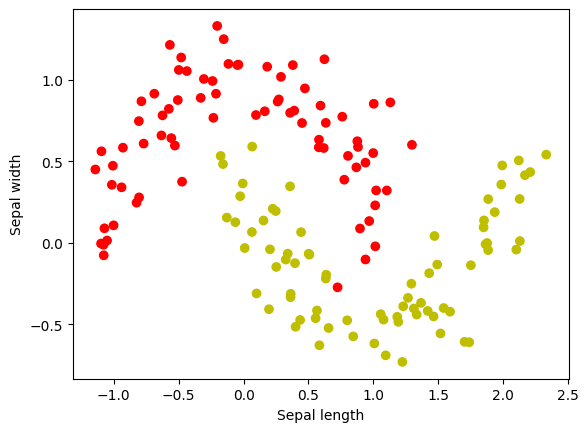

In [3]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [4]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [5]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [6]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [7]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [8]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0274)


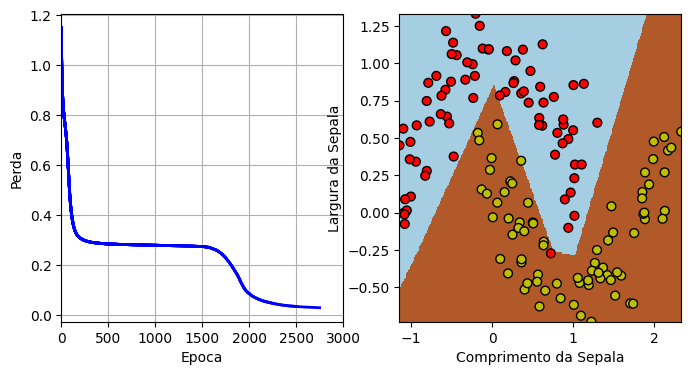

In [9]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [10]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 1.4217, -1.1287],
        [-0.3477, -0.6799],
        [ 3.0065,  0.1108],
        [-0.0562,  0.3310],
        [-0.8307,  1.1957]])
dense.0.bias    torch.Size([5])
tensor([ 1.5401, -0.5084, -0.1486, -0.4407,  1.9212])
dense.2.weight  torch.Size([5, 5])
tensor([[ 2.3428,  0.2010, -2.8216, -0.0116, -0.2262],
        [-0.2696,  0.1284,  0.1882, -0.4012,  0.1105],
        [-0.2336,  0.2987, -0.2117, -0.3261, -0.3024],
        [-0.4230, -0.2622, -0.2813,  0.4432, -0.1007],
        [ 0.3970,  0.4359,  0.9395,  0.3885, -2.3586]])
dense.2.bias    torch.Size([5])
tensor([ 0.3880, -0.3970, -0.2979, -0.3390, -0.7858])
dense.4.weight  torch.Size([3, 5])
tensor([[-1.8050e+00, -2.4002e-02, -3.3281e-01, -2.0519e-01, -2.0401e+00],
        [ 3.1053e+00,  2.7400e-01,  3.4816e-01,  4.0370e-01,  1.6955e+00],
        [-8.8158e-01, -4.1956e-01,  1.1680e-01,  1.9294e-01, -1.5916e-03]])
dense.4.bias    torch.Size([3])
tensor([ 4.2069, -1.2113, -2.5610])


### Avaliação do classificador

In [11]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.9866666666666667


### Matriz de confusão

In [12]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,74,1
1,1,74


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.



Treinando Modelo A (Camada oculta larga)...


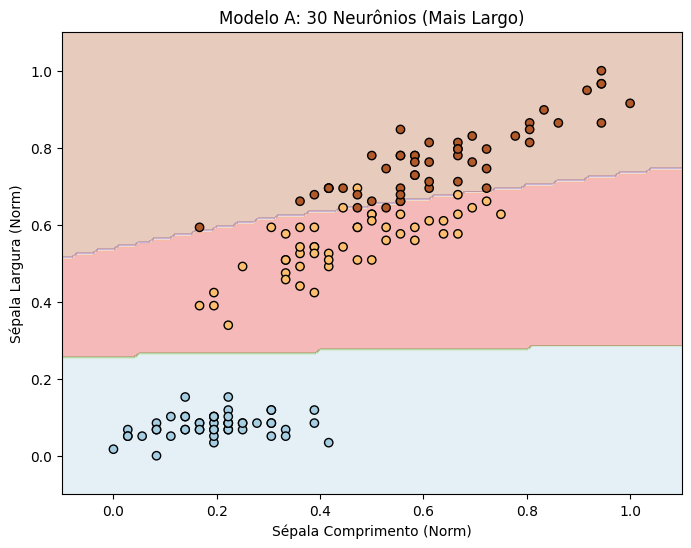

Treinando Modelo B (Rede Profunda/Deep)...


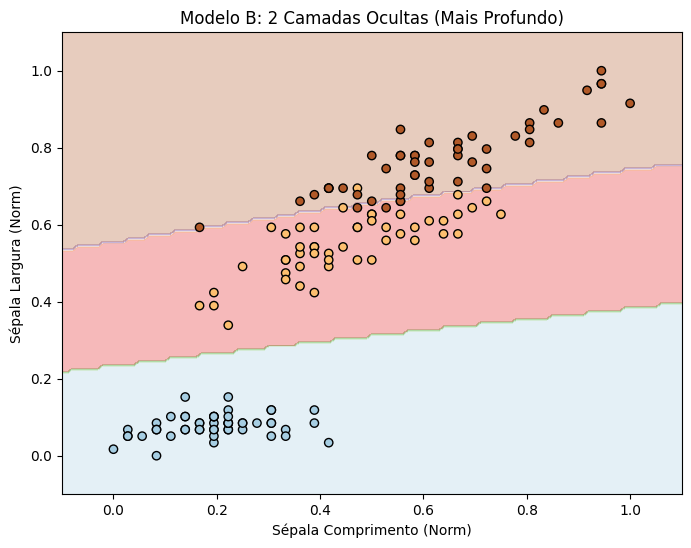

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

torch.manual_seed(1234)
iris = load_iris()
X = iris.data[:, ::2] 
Y = iris.target

Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc / Xs

X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

def plot_decision_boundary(model, title):

    x_min, x_max = Xc[:, 0].min() - 0.1, Xc[:, 0].max() + 0.1
    y_min, y_max = Xc[:, 1].min() - 0.1, Xc[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
 
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    

    with torch.no_grad():
        logits = model(grid_tensor)
        _, preds = torch.max(logits, 1)

    preds = preds.numpy().reshape(xx.shape)
  
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(Xc[:, 0], Xc[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel('Sépala Comprimento (Norm)')
    plt.ylabel('Sépala Largura (Norm)')
    plt.show()

print("Treinando Modelo A (Camada oculta larga)...")
model_a = nn.Sequential(
    nn.Linear(2, 30),   
    nn.ReLU(),          
    nn.Linear(30, 3)
)
optimizer_a = optim.SGD(model_a.parameters(), lr=0.15)
criterion = nn.CrossEntropyLoss()

for i in range(5000):
    output = model_a(X_tensor)
    loss = criterion(output, Y_tensor)
    optimizer_a.zero_grad()
    loss.backward()
    optimizer_a.step()

plot_decision_boundary(model_a, "Modelo A: 30 Neurônios (Mais Largo)")

print("Treinando Modelo B (Rede Profunda/Deep)...")
model_b = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 3)
)
optimizer_b = optim.SGD(model_b.parameters(), lr=0.15)

for i in range(5000):
    output = model_b(X_tensor)
    loss = criterion(output, Y_tensor)
    optimizer_b.zero_grad()
    loss.backward()
    optimizer_b.step()

plot_decision_boundary(model_b, "Modelo B: 2 Camadas Ocultas (Mais Profundo)")

O Modelo A, com mais neurônios na camada oculta, gera fronteiras de decisão mais suaves e flexíveis, melhor contornando os grupos de dados. Já o Modelo B, com mais camadas, aprende relações muito mais complexas, produzindo fronteiras irregulares e até regiões isoladas. Isso aumenta o poder de aprendizado, mas também o risco de overfitting em conjuntos de dados pequenos.

2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.

Treinando com Sigmoid...


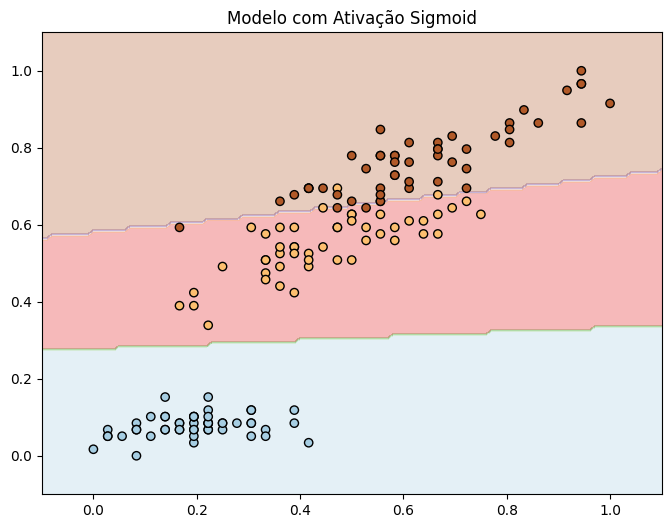

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

torch.manual_seed(1234)
iris = load_iris()
X = iris.data[:, ::2]
Y = iris.target

Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc / Xs

X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

def plot_decision_boundary(model, title):
    x_min, x_max = Xc[:, 0].min() - 0.1, Xc[:, 0].max() + 0.1
    y_min, y_max = Xc[:, 1].min() - 0.1, Xc[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        output = model(grid_tensor)
        _, preds = torch.max(output, 1)
    preds = preds.numpy().reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(Xc[:, 0], Xc[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

print("Treinando com Sigmoid...")

model_sigmoid = nn.Sequential(
    nn.Linear(2, 30),
    nn.Sigmoid(),     
    nn.Linear(30, 3)
)

optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.15)
criterion = nn.CrossEntropyLoss()

for i in range(5000):
    output = model_sigmoid(X_tensor)
    loss = criterion(output, Y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plot_decision_boundary(model_sigmoid, "Modelo com Ativação Sigmoid")

A troca da ReLU pela Sigmoid produziu fronteiras de decisão mais suaves e arredondadas, porque a Sigmoid é uma função contínua em forma de S, enquanto a ReLU cria cortes mais angulares por ser linear por partes. Porém, a Sigmoid sofre com vanishing gradient, o que pode tornar o aprendizado mais lento, especialmente em redes profundas. Já a ReLU aprende mais rápido por não saturar para valores positivos.

3. O que ocorre quando não se utiliza ativação não linear entre camadas?

Treinando rede sem ativação não-linear...


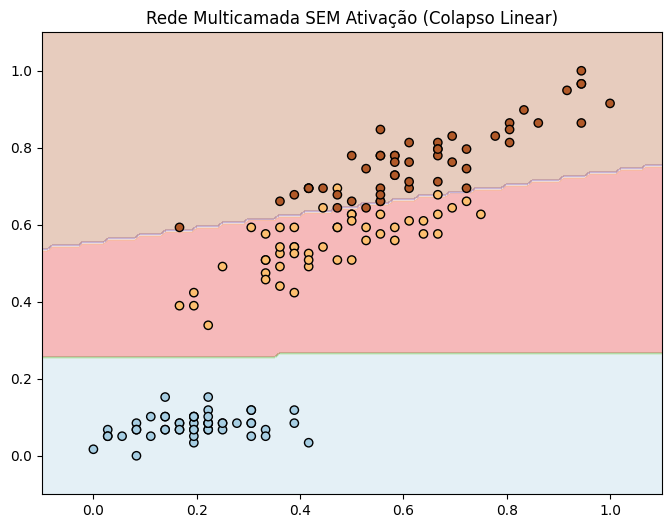

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

torch.manual_seed(1234)
iris = load_iris()
X = iris.data[:, ::2]
Y = iris.target
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc / Xs
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

def plot_decision_boundary(model, title):
    x_min, x_max = Xc[:, 0].min() - 0.1, Xc[:, 0].max() + 0.1
    y_min, y_max = Xc[:, 1].min() - 0.1, Xc[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        output = model(grid_tensor)
        _, preds = torch.max(output, 1)
    preds = preds.numpy().reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, preds, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(Xc[:, 0], Xc[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

print("Treinando rede sem ativação não-linear...")

model_linear = nn.Sequential(
    nn.Linear(2, 10),
    nn.Linear(10, 10),
    nn.Linear(10, 3)
)

optimizer = optim.SGD(model_linear.parameters(), lr=0.15)
criterion = nn.CrossEntropyLoss()

for i in range(5000):
    output = model_linear(X_tensor)
    loss = criterion(output, Y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plot_decision_boundary(model_linear, "Rede Multicamada SEM Ativação (Colapso Linear)")

Sem funções de ativação não lineares, mesmo redes profundas produzem apenas fronteiras de decisão lineares, porque múltiplas transformações lineares se reduzem a uma única transformação linear equivalente. Assim, a rede se comporta como uma simples Regressão Logística, incapaz de aprender curvas ou padrões complexos a profundidade deixa de ter utilidade.

## Principais aprendizados

A atividade mostrou como largura, profundidade e funções de ativação influenciam o poder de representação de uma MLP. Redes mais largas ou profundas conseguem criar fronteiras de decisão não lineares mais complexas. A ReLU produz separações mais angulares, enquanto a Sigmoid gera curvas suaves, mas pode sofrer com vanishing gradient. Já remover as ativações faz a rede se tornar puramente linear, eliminando sua capacidade de aprender padrões complexos e reduzindo-a a uma Regressão Logística, independentemente do número de camadas.